# Introduction

This notebook will consist of the following sections:

* **Problem Understanding:** Detailed explanation of the problem and definition of objectives.
* **Exploratory Data Analysis (EDA):** Analysis and visualization of the dataset, including an examination of class distributions.
* **Data Preprocessing:** Normalization of images, data augmentation, and splitting into training/validation datasets.
* **Model Construction & Traning & Tuning & Evaluation:** Experimentation with different CNN architectures to build the model. Training the model, hyperparameter optimization, and performance evaluation.
* **Conclusions:** General evaluation of the study and key takeaways.

# Problem Understanding


We have a dataset consisting of images with a resolution of 128x128 pixels, divided into six different classes. These classes are labeled as 0, 1, 2, 3, 4, and 5, corresponding to circle, triangle, rectangle, pentagon, hexagon, and star, respectively. Our goal is to build a Convolutional Neural Network (CNN) to classify these images. During this process, we will evaluate our performance using the accuracy score.

# Exploratory Data Analysis

First, let's check if all subclasses are present in our training dataset.

In [1]:
import os

# Define the path to the train folder
train_path = "/kaggle/input/math482-2024-2025-1-hw-05/train/train"  # Replace with your dataset path

# List all directories (classes) inside the train folder
classes = os.listdir(train_path)
print("Classes found in the dataset:", classes)


Classes found in the dataset: ['2', '5', '0', '3', '1', '4']


All classes appear to be present in the training file, and there are no issues.

Now, we need to:

* Check if the images are as expected, with dimensions of 128x128 pixels.
* Verify if all images are in the same format (e.g., .png, .jpg).

In [2]:
from PIL import Image  # Library for image processing
import random          # For selecting a random file

# Initialize a flag to track if any problems are found
all_images_valid = True

for class_name in classes:
    class_path = os.path.join(train_path, class_name)  # Get the full path of the class folder
    image_files = os.listdir(class_path)  # List all image files in the folder
    
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)  # Get the full path of the image
        
        # Open the image and check its size and format
        with Image.open(image_path) as img:
            if img.size != (128, 128) or img.format != "PNG":
                print(f"Problem found in Class: {class_name}, Image: {image_file}, Size: {img.size}, Format: {img.format}")
                all_images_valid = False  # Set the flag to False if an issue is found

# Final check and message
if all_images_valid:
    print("All images are valid: They have the correct size (128x128) and format (PNG). ")
else:
    print("Some images have issues. Please check the above logs.")


All images are valid: They have the correct size (128x128) and format (PNG). 


All our images are 128x128 pixels and in PNG format. Everything is fine.

Now, we will check how many images each class contains to evaluate the class distribution. Class distribution is crucial for us because if one class dominates or some classes are underrepresented in the training dataset, we will need to address and balance this issue.

In [3]:
# Dictionary to store class distribution
class_distribution = {}

for class_name in classes:
    class_path = os.path.join(train_path, class_name)  # Get the full path of the class folder
    image_files = os.listdir(class_path)  # List all image files in the folder
    
    # Count the number of images in this class
    class_distribution[class_name] = len(image_files)

# Print the distribution
for class_name, count in class_distribution.items():
    print(f"Class {class_name}: {count} images")




Class 2: 240 images
Class 5: 240 images
Class 0: 320 images
Class 3: 240 images
Class 1: 320 images
Class 4: 240 images



Only two classes have 320 images, while the others have 240 images each. We cannot say the distribution is completely balanced, but there is no significant imbalance either.

Now, we will take a general look at the images in our dataset. The purpose of this is to understand the nature of the images we are dealing with. We will examine factors such as the backgrounds, the orientation of the shapes, their colors, etc. To achieve this, we will create a mosaic for about 25% of the images from each class. A mosaic is a large image composed of smaller, resized images from the class, arranged in a grid.

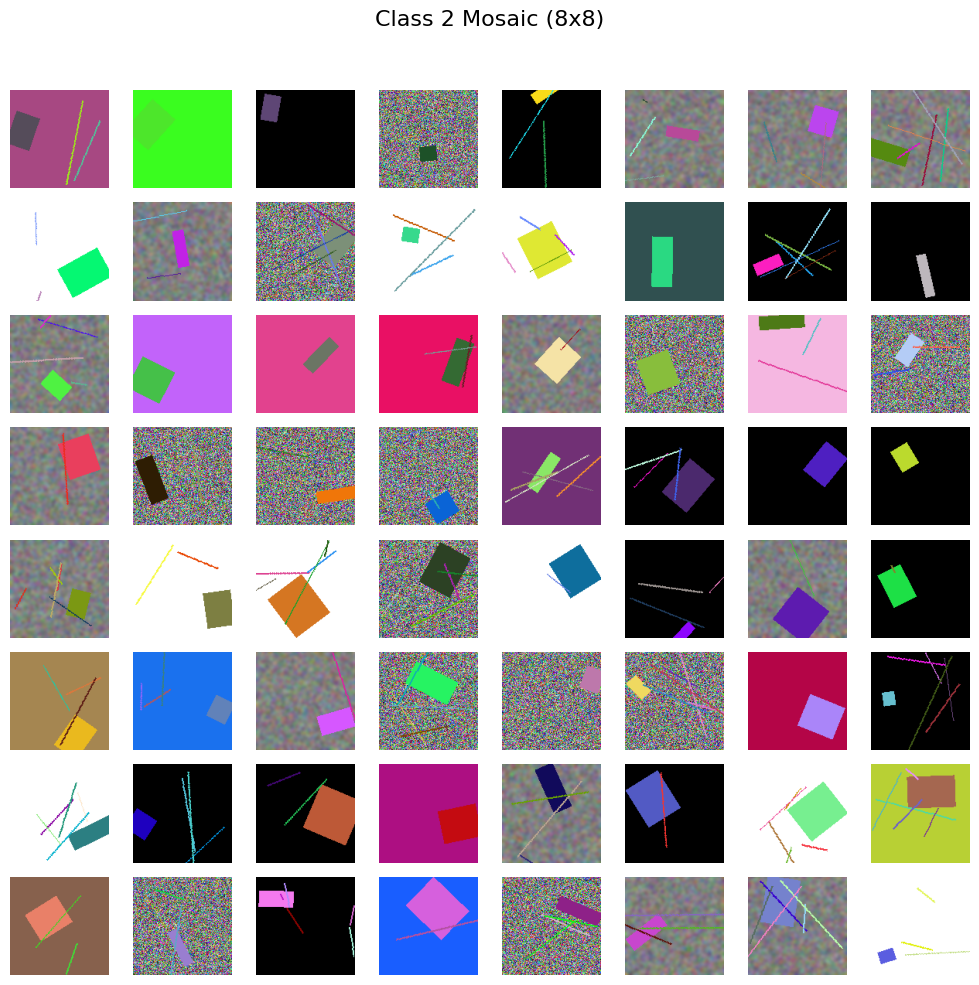

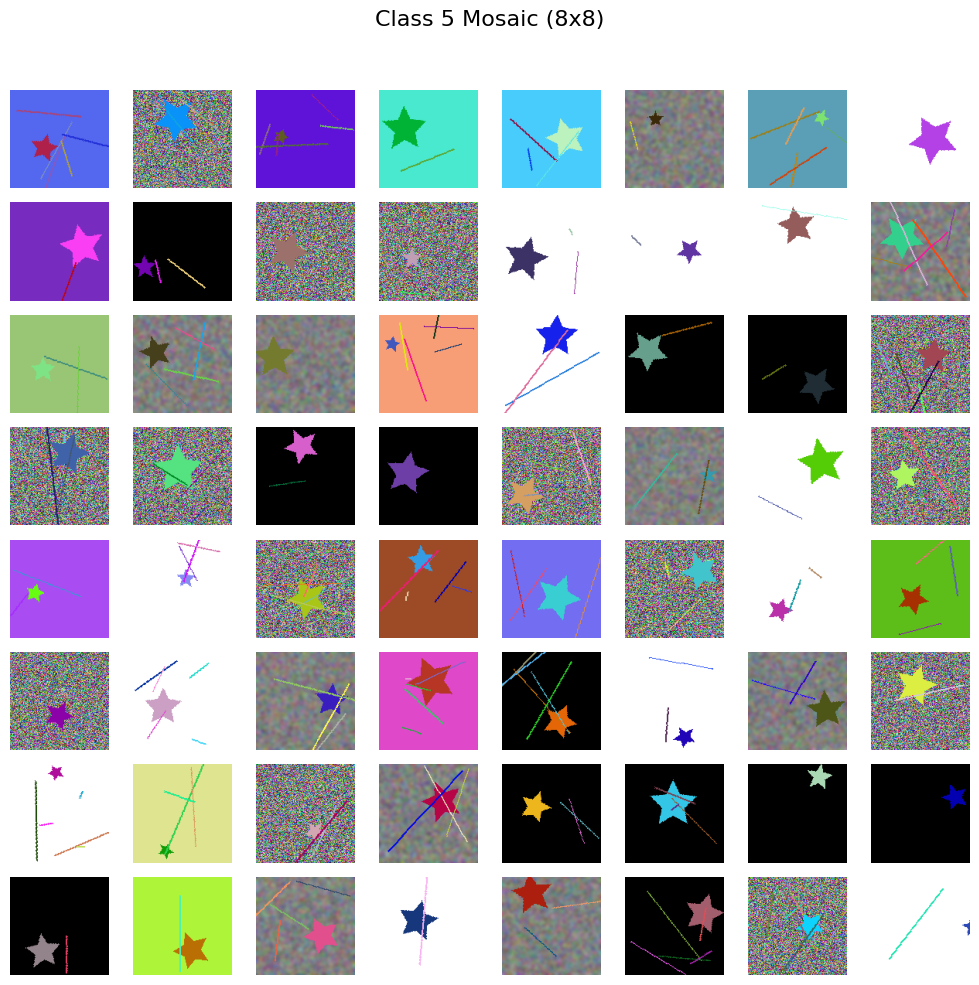

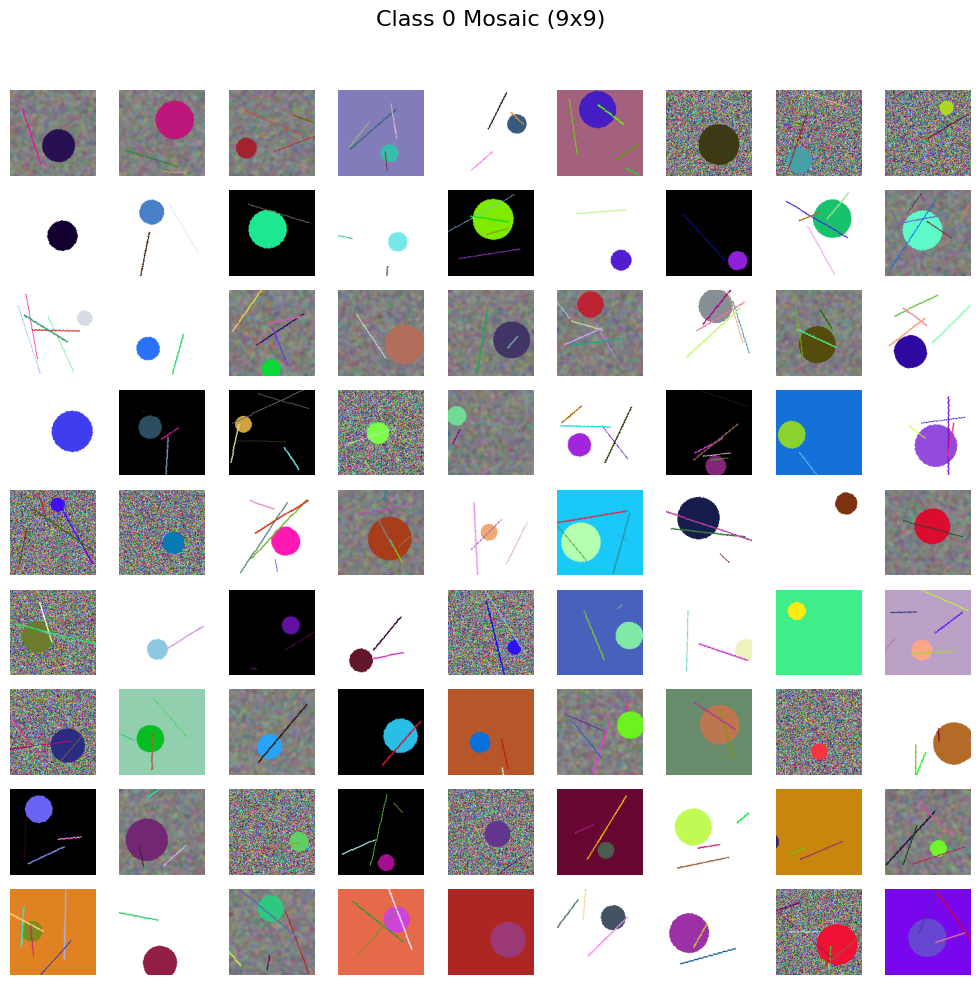

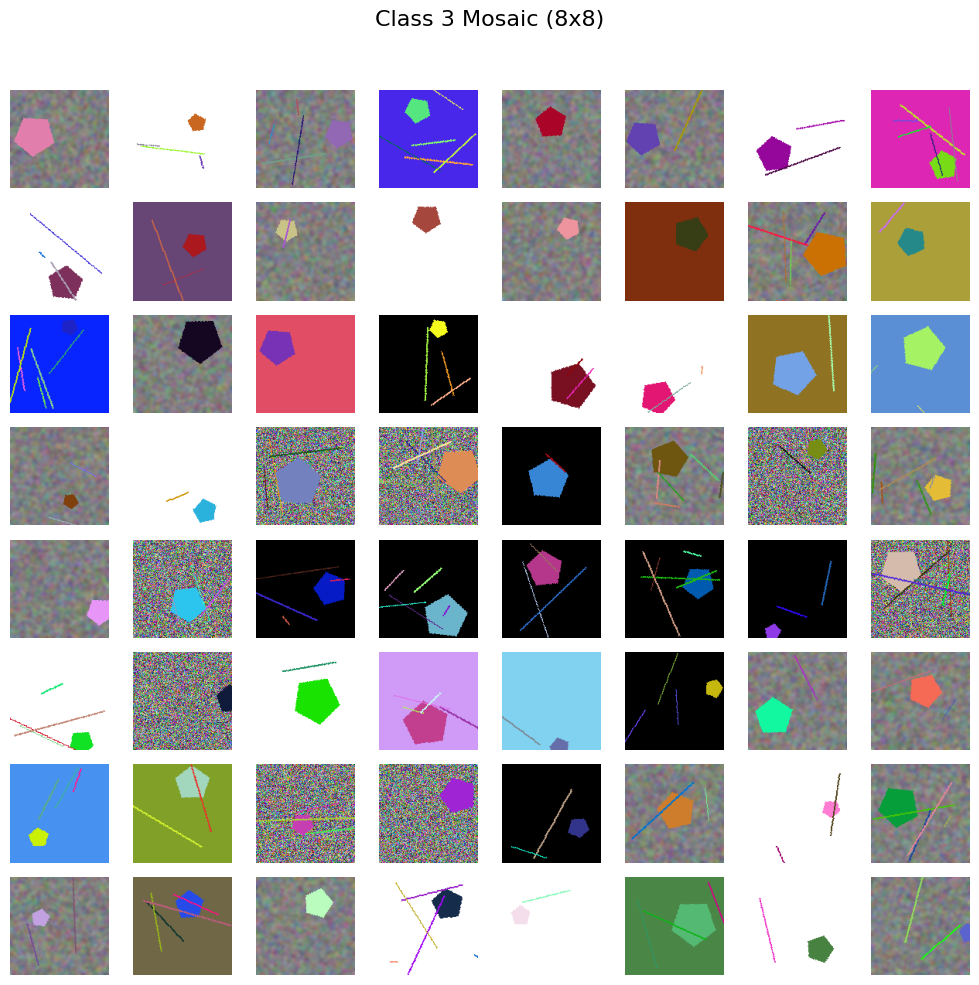

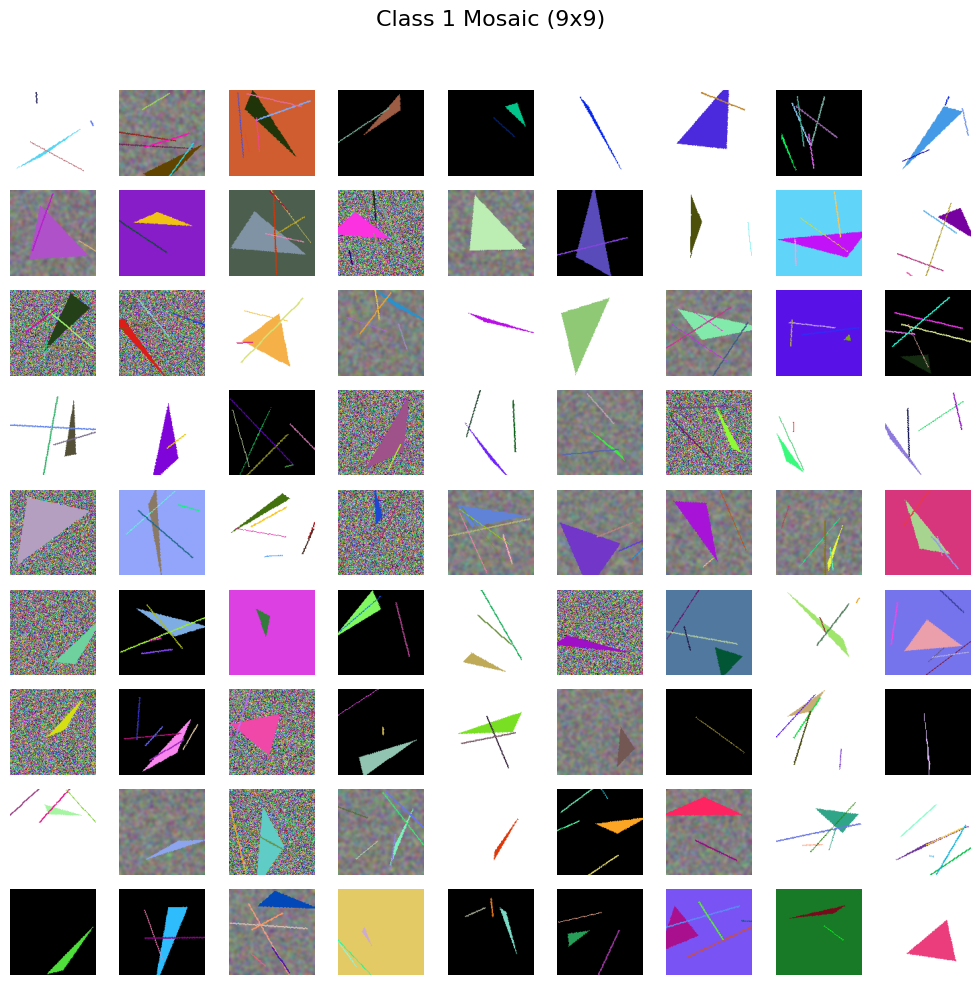

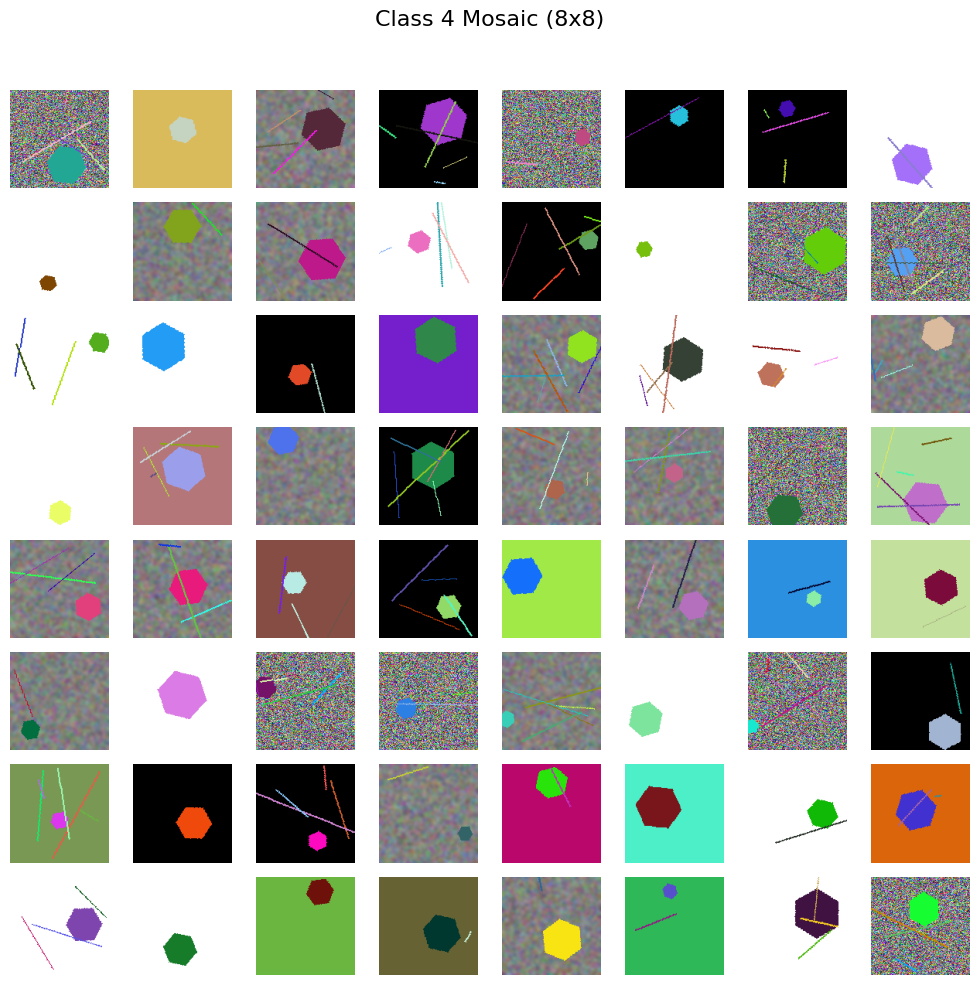

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

# Function to create mosaic for a given class
def create_mosaic(class_name, grid_size, img_folder):
    # Get the path of the class folder
    class_path = os.path.join(train_path, class_name)
    
    # Get all image files from the folder
    image_files = os.listdir(class_path)[:grid_size**2]  # Select only needed images for the grid
    
    # Create the figure for the mosaic
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    fig.suptitle(f'Class {class_name} Mosaic ({grid_size}x{grid_size})', fontsize=16)
    
    # Loop through the grid
    for i, ax in enumerate(axes.flat):
        if i < len(image_files):
            # Load the image
            img_path = os.path.join(class_path, image_files[i])
            img = Image.open(img_path).resize((128, 128))  # Resize to 128x128
            
            # Display the image
            ax.imshow(np.asarray(img))
            ax.axis('off')
        else:
            # Empty grid cell
            ax.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust title space
    plt.show()

# Loop through each class and create mosaics
for class_name in classes:
    # Determine grid size based on the number of images
    if len(os.listdir(os.path.join(train_path, class_name))) == 320:
        grid_size = 9  # 9x9 for 320 images
    else:
        grid_size = 8  # 8x8 for 240 images
    
    create_mosaic(class_name, grid_size, train_path)


As seen from the mosaics, there is a lot of variation and diversity in the shapes.

**Background Diversity:**
The backgrounds of the images appear to be quite variable. Some have white backgrounds, while others are black, blue, or in different colors. Additionally, there are random colorful patterns and noise present in the backgrounds. This diversity creates a good test environment for the model to focus on recognizing shapes instead of background-dependent features. However, such variability in backgrounds may require more attention and the application of data augmentation techniques during training.

**Shape Placement:**
The shapes are rotated at various angles and positioned in different areas of the image. This necessitates modeling features like rotation invariance and position invariance. While CNNs are generally effective at learning such variations, limited data can make this diversity a challenge.

**Extra Lines and Noise:**
 The images contain random lines, noise, and colorful patterns that could serve as distractions for the model. To ensure the model focuses solely on the shapes:

* Better data augmentation techniques can be applied, such as color normalization or edge detection.

* If these noises are not critical, a preprocessing step could be implemented to filter them out.

**Shape Variety:**
The sizes of the shapes also appear to be variable. Some shapes are large and prominent, while others are smaller. This indicates that the model will need scale invariance capabilities. CNNs typically learn such scale differences well, but it is important to support this with sufficient and diverse data.

Given the high level of diversity, the amount of data we have seems a bit limited. Therefore, we will address this issue using data augmentation techniques in the data preprocessing part.

# Data Preprocessing

Before splitting the dataset, we first organize the image file paths and their corresponding labels. This step is essential to ensure that the data is properly structured for training and validation. We then divide the dataset into training and validation sets using an 80-20 split. To maintain the class balance, we apply stratified sampling, which ensures that the proportion of samples for each class is consistent across both sets. This is particularly important in cases where class distributions are imbalanced, as it allows the model to learn from all classes equally. Additionally, we set a fixed random state to ensure reproducibility, enabling consistent results across multiple runs. By preparing the data in this way, we create a robust foundation for training and evaluating the model's performance effectively.

In [5]:
from sklearn.model_selection import train_test_split

# Create lists to store file paths and labels
file_paths = []
labels = []

# Loop through each class
for class_name in classes:
    class_path = os.path.join(train_path, class_name)  # Get the full path of the class folder
    image_files = os.listdir(class_path)  # List all image files in the folder
    
    # Add file paths and corresponding labels to the lists
    for image_file in image_files:
        file_paths.append(os.path.join(class_path, image_file))
        labels.append(class_name)

# Split the data into training and validation sets (80% train, 20% validation)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Print the number of samples in each set
print(f"Number of training samples: {len(train_paths)}")
print(f"Number of validation samples: {len(val_paths)}")



Number of training samples: 1280
Number of validation samples: 320


Now, we need to apply data augmentation preparing our data. At the same time, we also apply normalization our data. However, firstlt, I will give some explanation about what is normalization adn adata augmentation. After, we will continue with what is idea of our implemantation in our code.


**What is Normalization**

Normalization is a preprocessing technique used in machine learning and deep learning to scale input data into a specific range, typically [0, 1]. In the context of image data, normalization involves transforming pixel values, which usually range from 0 to 255 (for 8-bit images), into a smaller range. This is achieved by dividing each pixel value by 255, which maps the original range [0, 255] to [0, 1].



**What is Data Augmentation?**

Data augmentation is a technique used in machine learning and deep learning to artificially increase the size and diversity of a dataset by applying various transformations to the existing data. These transformations can include operations such as rotations, flips, shifts, zooms, and more, which simulate real-world variations in the data.

The primary goal of data augmentation is to improve the generalization ability of a model by making it more robust to changes and variations in input data. By exposing the model to a wider range of examples during training, data augmentation reduces the risk of overfitting, especially when working with limited datasets. This is particularly useful in image-based tasks, where transformations like flipping or rotating images can help the model learn invariant features such as object shapes, positions, and orientations.

In essence, data augmentation creates a richer and more varied dataset, enabling the model to perform better on unseen data. It is a cost-effective way to boost model performance without the need to collect additional data.

To prepare our data for training and validation, we use the ImageDataGenerator class from TensorFlow's Keras API. For the training set, we define a data augmentation pipeline to increase the diversity of our dataset and help the model generalize better. This augmentation includes normalization of pixel values to the [0, 1] range, random rotations, shifts, shear transformations, zooms, and horizontal flips. These transformations make the model robust to variations in the dataset, such as orientation and positioning of shapes.

For the validation set, we only apply pixel normalization without any augmentation, as the validation set is meant to represent unseen data and should not be altered. We then use flow_from_dataframe to create data generators for both the training and validation sets. This method links the file paths and labels to generate batches of data on the fly, resizing the images to 128x128 pixels and preparing them for multi-class classification using one-hot encoding. 

In [6]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Horizontally shift images
    height_shift_range=0.2,  # Vertically shift images
    shear_range=0.2,  # Apply shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flipping
    fill_mode='nearest'  # Fill missing pixels after transformation
)

# Define preprocessing for the validation set (no augmentation, only normalization)
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Generate augmented training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(128, 128),  # Resize images to 128x128
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)

# Generate validation data
val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(128, 128),  # Resize images to 128x128
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)


Found 1280 validated image filenames belonging to 6 classes.
Found 320 validated image filenames belonging to 6 classes.


The data are finally ready to be used in our models.









# Model Construction & Traning & Tuning

In this section, we will build several different models and observe how they produce varying results. The models we build will be trained immediately afterward, and then we will evaluate them in the model evaluation part. While training our models, we will use different activation functions and optimizers, recording the results. Later, we will compare the best outcomes.

Before building our models, I would like to provide some information about what is Convolutional Neural Newtork, activation functions and optimizers.

### What is Convolutional Neural Network(CNN)

* CNN (Convolutional Neural Network) is a deep learning model frequently used in image processing and computer vision. Unlike standard artificial neural networks, it is designed to preserve the spatial structure and neighborhood relationships of input data (e.g., an image).

**Key Features**
 
**Convolution Layers:**
* Captures features by sliding small weight matrices, called filters or kernels, over the input (image).
* Filters learn various visual features, such as edges, corners, and textures.

**Activation Functions**
* Activation functions like ReLU or Leaky ReLU, which follow the convolution layers, introduce non-linearity, enabling the model to learn complex relationships.

**Pooling Layers**
* Methods like Max Pooling or Average Pooling reduce spatial sensitivity, enhance generalization, and lower computational cost.
* In more complex models, Global Average Pooling or Global Max Pooling can also be used.
 
**Fully Connected Layers**
* Located at the end of the model and responsible for classification (or regression) tasks.
The features extracted by the network are utilized in these layers to make the final decision.


**Weight Sharing**

* In CNNs, the same filter is applied across the entire input, significantly reducing the number of parameters and simplifying training.
* This allows for more efficient use of memory and computational capacity.

### Activation Functions

1. **ReLU (Rectified Linear Unit):**  
   ReLU is the most commonly used activation function in CNNs due to its simplicity and effectiveness. It is defined as:  

   $$
   f(x) = \max(0, x)
   $$  

   All negative values are replaced with 0, while positive values remain unchanged. This non-linear function introduces sparsity into the network and helps mitigate the vanishing gradient problem, allowing for faster and more efficient training. However, ReLU can suffer from the **"dying ReLU"** problem, where some neurons become inactive and stop learning if their outputs consistently fall below 0.

---

2. **Sigmoid:**  
   The sigmoid activation function maps input values to the range (0, 1) using the formula:  

   $$
   f(x) = \frac{1}{1 + e^{-x}}
   $$  

   It is commonly used in the output layer for binary classification tasks. While sigmoid is smooth and differentiable, it is less commonly used in hidden layers of CNNs because it can lead to **vanishing gradients**, especially in deeper networks. This happens because the gradients become very small for inputs far from 0, slowing down the learning process.

---

3. **Tanh (Hyperbolic Tangent):**  
   Tanh is similar to sigmoid but maps inputs to the range (-1, 1) instead of (0, 1). It is defined as:  

   $$
   f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
   $$  

   Tanh is often preferred over sigmoid for hidden layers because its output is zero-centered, which helps balance the gradients during backpropagation. However, like sigmoid, it can also suffer from **vanishing gradients** for very large or small input values.

---

4. **Swish:**  
   Swish is a newer activation function defined as:  

   $$
   f(x) = x \cdot \sigma(x)
   $$  

   Where $\sigma(x)$ is the sigmoid function. Swish is smooth and non-monotonic, allowing for better gradient flow. It has been shown to outperform ReLU in some deep neural networks, particularly in very deep models.



### Optimization Algorithms

1. **SGD (Stochastic Gradient Descent):**  
   SGD is one of the simplest and most widely used optimizers in deep learning. It updates model weights iteratively using the formula:  

   $$
   w = w - \eta \cdot \nabla L(w)
   $$  

   Where:
   - $( \eta )$: Learning rate,  
   - $( \nabla L(w))$: Gradient of the loss function with respect to the weights.  

   While computationally efficient, SGD may converge slowly or get stuck in local minima, especially with noisy gradients or saddle points. Performance can be improved with momentum or adaptive learning rates.

---



---

2. **RMSProp (Root Mean Square Propagation):**  
   RMSProp adjusts the learning rate for each parameter individually using an exponentially decaying average of squared gradients:  

   $$
   g_t = \beta g_{t-1} + (1 - \beta) (\nabla L(w))^2
   $$  
   $$
   w = w - \frac{\eta}{\sqrt{g_t} + \epsilon} \nabla L(w)
   $$  

   RMSProp ensures stable convergence and is particularly effective for non-stationary objectives, making it ideal for deep networks.

---

3. **Adam (Adaptive Moment Estimation):**  
   Adam combines Momentum and RMSProp, maintaining both the first moment (mean) and second moment (variance) of the gradients. The formulas are:  

   $$
   m_t = \beta_1 m_{t-1} + (1 - \beta_1) \nabla L(w)
   $$  
   $$
   v_t = \beta_2 v_{t-1} + (1 - \beta_2) (\nabla L(w))^2
   $$  
   $$
   \hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
   $$  
   $$
   w = w - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
   $$  

   Adam dynamically adapts learning rates and performs well across a variety of tasks, making it one of the most popular optimizers.

---

4. **Adagrad (Adaptive Gradient Algorithm):**  
   Adagrad adapts learning rates for each parameter based on the accumulated gradients:  

   $$
   w = w - \frac{\eta}{\sqrt{G_t} + \epsilon} \nabla L(w)
   $$  

   Where:
   - $( G_t )$: Sum of squared gradients.  

   While effective for sparse data, Adagrad suffers from decaying learning rates over time.

---



## CNN Models

### Basic CNN Model

This CNN model is designed for a 6-class classification problem by extracting features from images. The input layer accepts 128x128 color images. The first three convolutional layers operate with 32, 64, and 128 filters, respectively, to learn both low- and high-level features from the images, each using ReLU activation. MaxPooling layers reduce the feature map sizes, lowering computational costs and enhancing generalization. The Flatten layer transforms the 2D feature maps into a 1D vector for classification. The fully connected layer processes features with 128 neurons and ReLU activation, while the Dropout layer randomly disables some neurons to prevent overfitting. The output layer uses softmax activation to generate a probability distribution for the 6 classes. The model is compiled with the Adam optimization algorithm and the categorical_crossentropy loss function, evaluated using the accuracy metric. This architecture effectively extracts meaningful features from images for accurate classification.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Define the CNN model
basic_model = Sequential([
    # Define the input layer explicitly
    Input(shape=(128, 128, 3)),  # Input layer with shape
    
    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu'),  # 32 filters, 3x3 kernel
    MaxPooling2D((2, 2)),  # 2x2 max pooling
    
    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Convolutional layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Flatten the output for the dense layers
    Flatten(),
    
    # Fully connected layer
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    
    # Output layer
    Dense(6, activation='softmax')  # 6 classes, softmax activation
])

# Compile the model
basic_model.compile(
    optimizer='adam',  # Adam optimizer
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Evaluation metric
)

# Print the model summary
basic_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,414 (12.61 MB)

 Trainable params: 3,305,414 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - accuracy: 0.2029 - loss: 1.9214 - val_accuracy: 0.2031 - val_loss: 1.7858
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.2105 - loss: 1.7856 - val_accuracy: 0.2000 - val_loss: 1.7847
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.2051 - loss: 1.7902 - val_accuracy: 0.2031 - val_loss: 1.7840
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.2028 - loss: 1.7851 - val_accuracy: 0.1937 - val_loss: 1.7803
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.2180 - loss: 1.7827 - val_accuracy: 0.1969 - val_loss: 1.7834
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.2024 - loss: 1.7839 - val_accuracy: 0.1969 - val_loss: 1.7825
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.2104 - loss: 1.7835 - val_accuracy: 0.2031 - val_loss: 1.7871
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.1855 - loss: 1.7770 - val_accuracy: 0.2000 - val

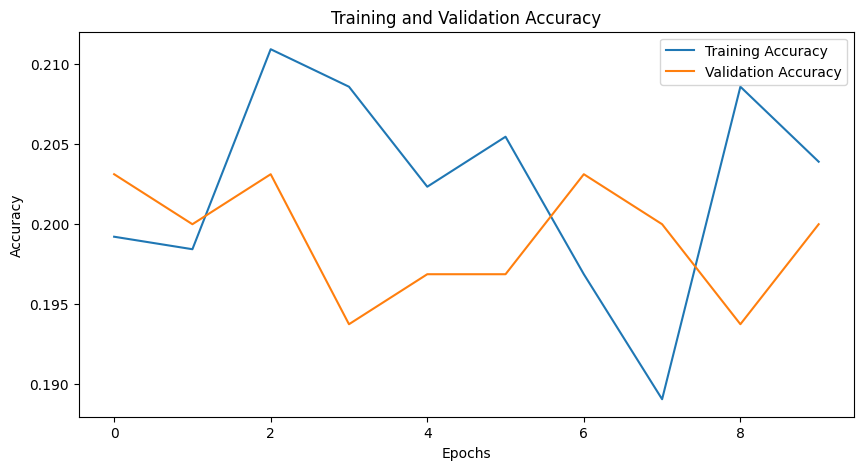

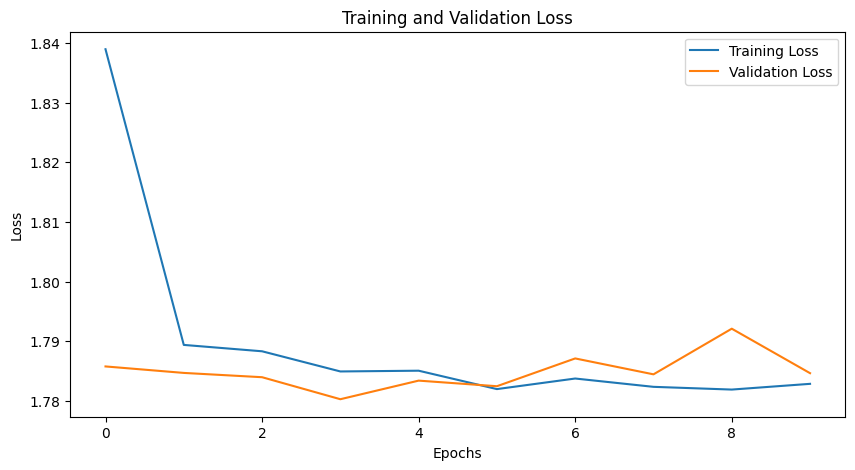

In [8]:
# Train the model with adjusted steps_per_epoch and validation_steps
history = basic_model.fit(
    train_generator,  # Training data
    validation_data=val_generator,  # Validation data
    epochs=10,  # Number of epochs
    verbose=1  # Display training progress
)

# Plot the training and validation accuracy/loss
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



We did not achieve satisfactory results with this model, so I will not test it with different activation functions and optimizers. Instead, we will now build a much more complex and pre-trained model. This model is expected to deliver better results.

## Pretrained CNN Models


Pretrained CNN models eliminate the need to train a model from scratch by leveraging training on large datasets, saving both time and computational resources. These models can effectively extract generalized low-level features (e.g., edge detection, texture recognition), making them highly efficient even when working with small datasets while reducing the risk of overfitting. With fine-tuning, these models can be adapted to new tasks, achieving high performance with minimal labeled data and reducing the effort required for data annotation. Additionally, they offer a wide range of models for various tasks (e.g., ResNet, VGG, MobileNet), enabling rapid prototyping and often delivering better accuracy compared to models trained from scratch. For these reasons, pretrained models provide significant advantages in deep learning projects in terms of both efficiency and performance.

### Model VGG16

VGG16 is a widely used Convolutional Neural Network (CNN) model in the field of deep learning, named for its 16 weight layers. It is known for its exceptional performance in tasks such as image classification and feature extraction. The model's core structure consists of convolutional layers with small-sized (3x3) filters arranged sequentially, followed by max-pooling layers. This architecture allows the model to learn deeper features with fewer parameters. Additionally, fully connected layers utilize the extracted features to perform the final classification.

VGG16 is particularly notable for achieving high accuracy in tasks involving visual data and comes with pre-trained weights on the ImageNet dataset, like most pretrained models. Its straightforward architecture, generalization ability, and suitability for transfer learning make VGG16 a preferred model for various deep learning projects.

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# List of activation functions to try
activation_functions = ['relu', 'sigmoid', 'tanh', 'swish']

# Dictionary to store histories for comparison
histories = {}

# Loop through each activation function
for activation in activation_functions:
    # Load the pretrained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Freeze the pretrained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation=activation)(x)  # Apply the activation function here
    x = Dropout(0.5)(x)
    output = Dense(6, activation='softmax')(x)  # Output layer remains softmax for multi-class classification

    # Define the model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    print(f"Training with activation function: {activation}")
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,  # Use fewer epochs for quick testing
        verbose=1
    )
    
    # Save the history for comparison
    histories[activation] = history



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training with activation function: relu
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.2090 - loss: 1.9799 - val_accuracy: 0.5344 - val_loss: 1.4290
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.4289 - loss: 1.4840 - val_accuracy: 0.5406 - val_loss: 1.2602
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.5056 - loss: 1.3222 - val_accuracy: 0.6281 - val_loss: 1.1380
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.5423 - loss: 1.2446 - val_accuracy: 0.6375 - val_loss: 1.0642
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.5826 - loss: 1.1408 - val_accuracy: 0.6719 - val_loss: 0.9902
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.5656 - loss: 1.1227 - val_accuracy: 0.6406 - val_loss: 0.9574
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.5978 - loss: 1.0601 - val_accuracy: 0.6500 - val_loss: 0.9327
Epoch 8/10
4

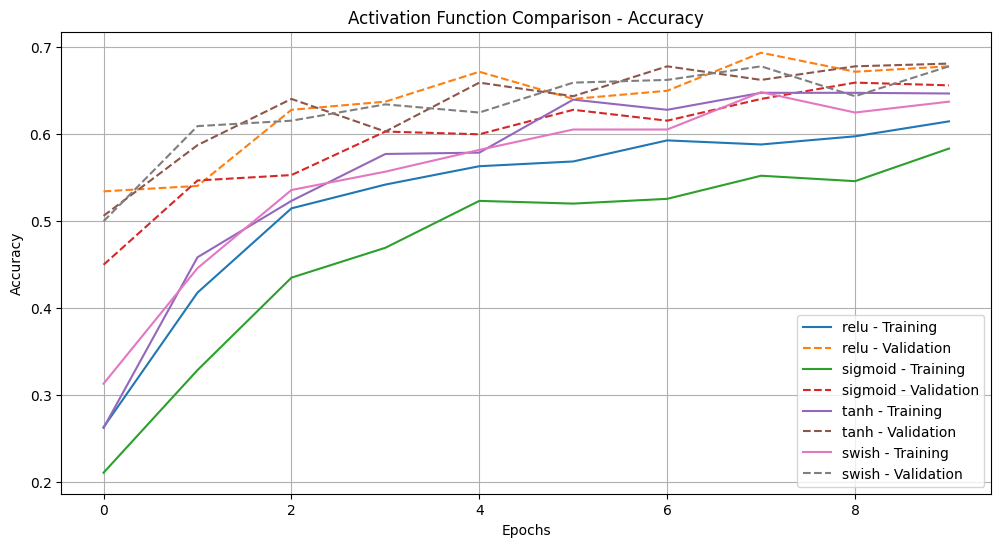

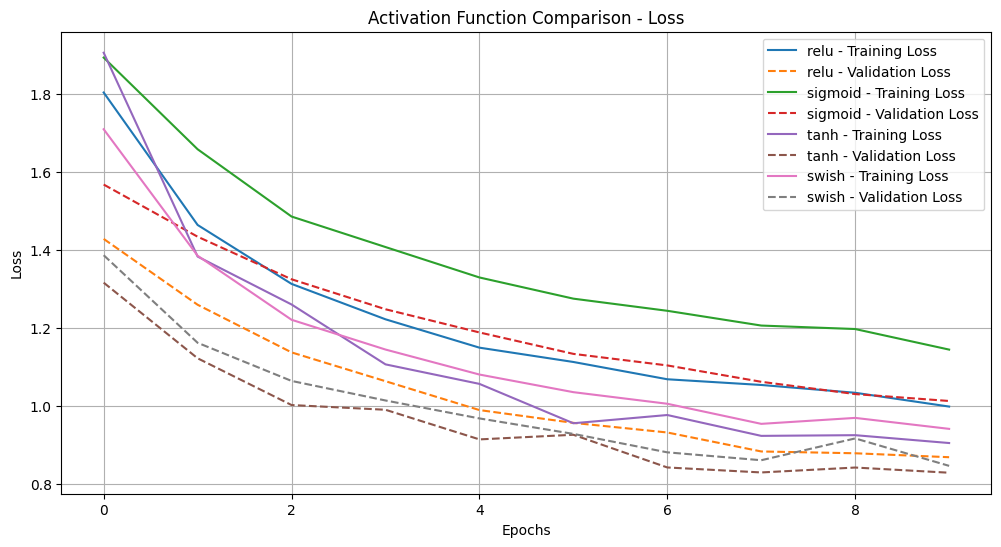

In [10]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
for activation, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{activation} - Training')
    plt.plot(history.history['val_accuracy'], linestyle='dashed', label=f'{activation} - Validation')

plt.title('Activation Function Comparison - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
for activation, history in histories.items():
    plt.plot(history.history['loss'], label=f'{activation} - Training Loss')
    plt.plot(history.history['val_loss'], linestyle='dashed', label=f'{activation} - Validation Loss')

plt.title('Activation Function Comparison - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Clearly, the best performing activation function is tanh. Now, fix tanh as an activation function and train model each time for each optimizer.

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
import matplotlib.pyplot as plt

# List of optimizers to try
optimizers = {
    'Adam': 'adam',
    'SGD': 'sgd',
    'RMSProp': 'rmsprop',
    'Adagrad': 'adagrad'
}

# Dictionary to store histories for comparison
histories = {}

# Loop through each optimizer
for optimizer_name, optimizer in optimizers.items():
    # Load the pretrained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Freeze the pretrained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='tanh')(x)  # Use 'tanh' activation
    x = Dropout(0.5)(x)
    output = Dense(6, activation='softmax')(x)  # Output layer for 6 classes

    # Define the model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with the specific optimizer
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    print(f"Training with optimizer: {optimizer_name}")
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,  # Use fewer epochs for testing purposes
        verbose=1
    )
    
    # Save the history for comparison
    histories[optimizer_name] = history


Training with optimizer: Adam
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.2686 - loss: 2.6186 - val_accuracy: 0.5250 - val_loss: 1.2722
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.4293 - loss: 1.5970 - val_accuracy: 0.5781 - val_loss: 1.0331
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.4797 - loss: 1.4811 - val_accuracy: 0.6344 - val_loss: 0.9721
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.5060 - loss: 1.3604 - val_accuracy: 0.6281 - val_loss: 0.9496
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.5256 - loss: 1.3183 - val_accuracy: 0.6844 - val_loss: 0.8623
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.5921 - loss: 1.1532 - val_accuracy: 0.6625 - val_loss: 0.8545
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.5249 - loss: 1.2718 - val_accuracy: 0.6625 - val_loss: 0.8491
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.5580 - 

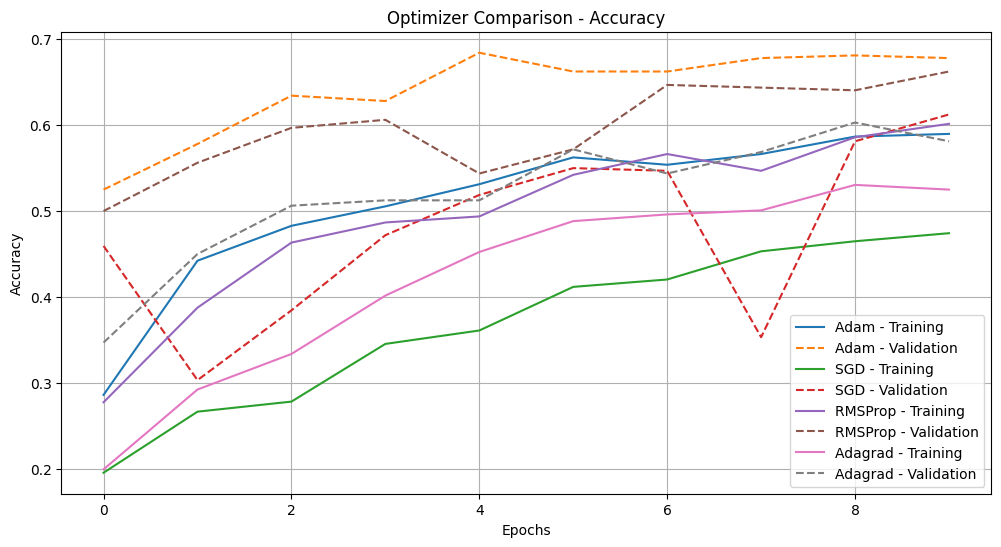

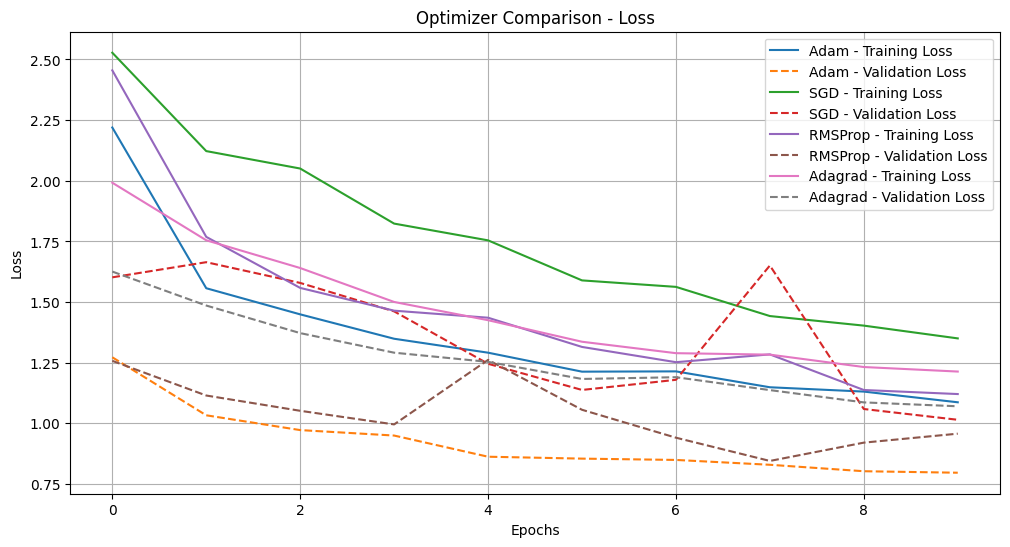

In [12]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
for optimizer_name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{optimizer_name} - Training')
    plt.plot(history.history['val_accuracy'], linestyle='dashed', label=f'{optimizer_name} - Validation')

plt.title('Optimizer Comparison - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
for optimizer_name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{optimizer_name} - Training Loss')
    plt.plot(history.history['val_loss'], linestyle='dashed', label=f'{optimizer_name} - Validation Loss')

plt.title('Optimizer Comparison - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Now, to improve the performance of our model, we will make the custom layers we added more sophisticated. We will apply L2 regularization and unfreeze some layers of the pretrained VGG16 model.

In [13]:
from tensorflow.keras.regularizers import l2

# Load the pretrained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)  # Flatten the feature maps to a 1D vector

# Add a fully connected layer with L2 regularization
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # Regularization term to prevent overfitting
x = Dropout(0.5)(x)  # Dropout to randomly deactivate neurons and improve generalization

# Add another fully connected layer
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)

# Add the output layer for classification (6 classes)
output = Dense(6, activation='softmax', kernel_regularizer=l2(0.01))(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with a low learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Adam optimizer with a low learning rate for stable training
    loss='categorical_crossentropy',    # Loss function for multi-class classification
    metrics=['accuracy']                # Metric to evaluate the model's performance
)

# Print the model summary
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 19,042,374 (72.64 MB)

 Trainable params: 4,327,686 (16.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,  
        verbose=1
    )

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 221ms/step - accuracy: 0.1485 - loss: 15.3021 - val_accuracy: 0.3219 - val_loss: 14.6142
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.1980 - loss: 14.7340 - val_accuracy: 0.4219 - val_loss: 14.2610
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.2591 - loss: 14.3097 - val_accuracy: 0.5031 - val_loss: 13.8105
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.3397 - loss: 13.9218 - val_accuracy: 0.5562 - val_loss: 13.3563
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.4273 - loss: 13.4747 - val_accuracy: 0.6438 - val_loss: 12.9952
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.4990 - loss: 13.1623 - val_accuracy: 0.7094 - val_loss: 12.5816
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.5501 - loss: 12.8584 - val_accuracy: 0.7625 - val_loss: 12.2900
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.6239 - loss: 12.5434 - 

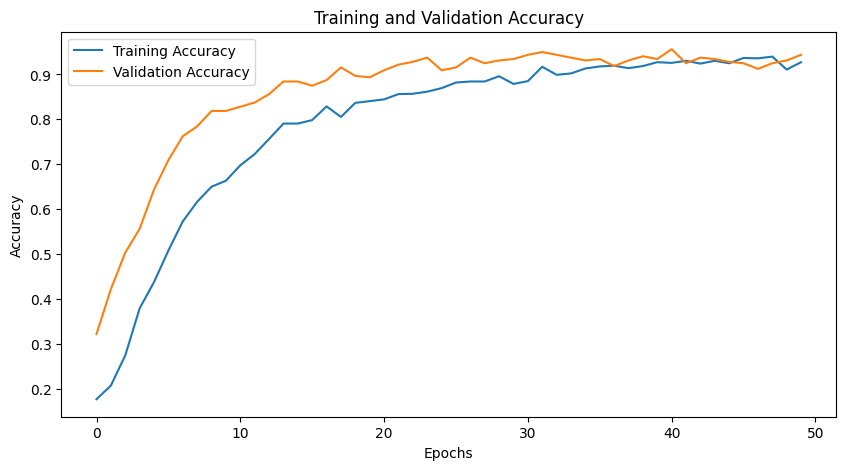

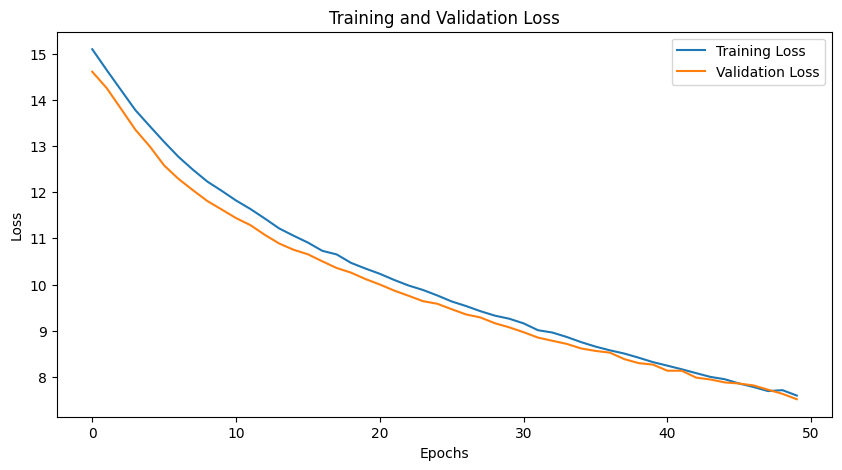

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Conclusion

Experiments have been conducted on different model architectures and optimization techniques, and the results of these studies have been compared. In the initial experiments with a simple CNN model, the low training accuracy and validation accuracy closely aligning with training accuracy indicated that the model's limited learning capacity was the primary issue rather than overfitting. In experiments with VGG16-based models, Tanh and Swish activation functions delivered the best performance, while ReLU was successful in training accuracy but failed to achieve similar levels in validation accuracy. Sigmoid, on the other hand, yielded the lowest accuracy due to saturation problems.

When analyzing optimization techniques, the Adam optimizer consistently provided the best validation accuracy with a stable learning curve. SGD showed slower accuracy improvements but generally delivered stable results, while RMSProp was effective in specific scenarios, and Adagrad exhibited the lowest performance. Models with added regularization and Dropout demonstrated better alignment between training and validation accuracy, significantly reducing overfitting; however, validation accuracy plateaued at around 90-92%.

In fine-tuning experiments, increasing the number of layers improved training accuracy but caused validation accuracy to plateau, indicating that the model had reached its generalization limits. Overall, architectures based on the VGG16 model combined with the Tanh activation function and Adam optimizer delivered the best results, particularly in terms of validation accuracy. However, the plateauing of accuracy levels suggests limitations imposed by the dataset or the model architecture.